In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.transforms import ToTensor
from torchvision import transforms
import glob
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from IPython.display import clear_output
import math
import time
import sys
import DifferentiableAugmentation as DA

In [32]:
from sklearn.cluster import KMeans #import a random package to avoid kernel death when using pyplot (makes no sense but works)

In [33]:
def extractLabels(file, color = np.array([None]), quantile = sys.float_info.max):
    
    if color.all() != None:
        return [np.mean(color)]
    
    backup = file
    if 'nan' in file:
        #print(backup)
        return None
    file = file.split("\\")[1]
    file = file.split("_", 16)
    file[16] = file[16].split('.', 1)[0]
    #remove useless labels
    del file[16] #'Random string'
    del file[15] #'Body Style'
    del file[14] #'Passenger Doors',
    del file[13] #'Passenger Capacity'
    del file[12] #'Drivetrain'
    del file[11] #'Gas Mileage'
    del file[10] #'Length, Overall (in)'
    del file[9] #'Height, Overall (in)'
    del file[8] #'Width, Max w/o mirrors (in)'
    del file[7] #'Engine Type'
    del file[6] #'Displacement'
    #del file[5] #'SAE Net Horsepower @ RPM'
    del file[4] #'Front Wheel Size (in)'
    del file[3] #'MSRP' Prix
    del file[2] #'Year'
    del file[1] #'Model'
    del file[0]#Make'
    
    try:
        file = [int(float(i)) for i in file]
    except Exception as e: #get name of file who raises an error
        print(backup)
        return None
    if(file[0] <= quantile):
        return file
    else:
        return None

In [34]:
def Normalize_labels(labels):
    for i in range(labels.shape[1]):
        minimum = labels[:,i].min()
        maximum = labels[:,i].max()
        print(minimum, maximum)
        for j in range(labels.shape[0]):
            labels[j,i] = (labels[j,i] - minimum)/(maximum - minimum)
    return labels  

num = 3000
tensorLab_list = []
None_id = []
i = 0

for filename in glob.glob('Data/Cars/*.jpg'):
    labels = extractLabels(filename)
    if labels != None:
        tensorLab_list.append(torch.FloatTensor(labels))
    else: None_id.append(i)
    i += 1
    #if i >= num: break
LabelsTens = torch.stack(tensorLab_list)
LabelsTens = Normalize_labels(LabelsTens)

NO_bg

In [35]:
num = 3000
tensorLab_list = []
None_id = []
i = 0

color = False

PATH = 'Data/colorsv3.npy'
colors = np.load(PATH)

q95_RPM = 460


for filename in glob.glob('Data/No_background/*.jpg'):
    if color:
        labels = extractLabels(filename, color = colors[i]) #to extract colors
    else:
        labels = extractLabels(filename, quantile = q95_RPM)
    if labels != None:
        tensorLab_list.append(torch.FloatTensor(labels))
    else: None_id.append(i)
    i += 1
    #if i >= num: break
    
LabelsTens = torch.stack(tensorLab_list)
LabelsTens = Normalize_labels(LabelsTens)

Data/No_background\Chevrolet_Volt_2011_40_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_lgT.jpg
Data/No_background\Chevrolet_Volt_2011_40_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_OCX.jpg
Data/No_background\Chevrolet_Volt_2011_40_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_qby.jpg
Data/No_background\Chevrolet_Volt_2011_40_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_ZQr.jpg
Data/No_background\Chevrolet_Volt_2012_39_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_aOM.jpg
Data/No_background\Chevrolet_Volt_2012_39_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_hpF.jpg
Data/No_background\Chevrolet_Volt_2012_39_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_oLC.jpg
Data/No_background\Chevrolet_Volt_2012_39_17_- 0_14_4_70_56_177_35_FWD_4_4_4dr_Wva.jpg
tensor(100.) tensor(460.)


In [6]:
print(LabelsTens.shape)
print(LabelsTens)

torch.Size([15332, 1])
tensor([[0.0278],
        [0.0278],
        [0.0278],
        ...,
        [0.4167],
        [0.4167],
        [0.4167]])


<BarContainer object of 30 artists>

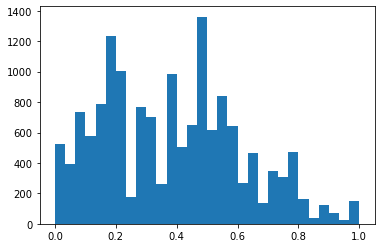

In [36]:
plt.hist(LabelsTens.view(-1).tolist(), np.arange(torch.min(LabelsTens),torch.max(LabelsTens)+1/30,1/30))[2]

In [7]:
num = 3000
image_size = 64
total_files = 19921
current_perc = 0

tensorIm_list = []
i = 0


for filename in glob.glob('Data/No_background/*.jpg'):
    
    image=np.array(Image.open(filename))
    
    lengths = image.shape
    gap = np.abs(lengths[0] - lengths[1])
    argm = np.argmax(lengths)
    if argm == 0:
        pads = [int(gap/2),0,int(gap/2),0]
    else:
        pads = [0,int(gap/2),0,int(gap/2)]
    
    
    transform=T.Compose([
        T.ToPILImage(),
        T.Pad(pads, fill = 255),
        T.Resize(image_size),
        T.ToTensor()])
    
    image = transform(image)
    if(i not in None_id): tensorIm_list.append(image)
    if math.floor(i/total_files*100) > current_perc:
        current_perc += 1
        s = '[' + '-'*current_perc + str(current_perc+1) + '%' + ' '*(99-current_perc)+ ']'
        print('       ----------------------------------------Loading Data----------------------------------------', '\n', s)
        clear_output(wait=True)
        
        
    i += 1
    #if i >= num: break
CarsTens = torch.stack(tensorIm_list)

KeyboardInterrupt: 

In [8]:
print(CarsTens.shape)

torch.Size([15332, 3, 64, 64])


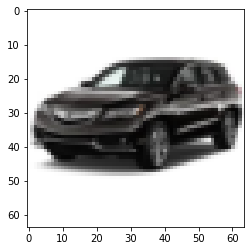

In [9]:
plt.imshow(CarsTens[161].permute(1,2,0))

In [8]:
class Train_Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self):
        'Initialization'

    def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return LabelsTens.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = CarsTens[index]
        y = LabelsTens[index]

        return X, y

In [9]:
batch_size = 32

dl = Train_Dataset()
train_loader = torch.utils.data.DataLoader(dl, batch_size=batch_size,shuffle=True)
test = next(iter(train_loader))
print(f"X_component: {test[0].shape} \nY-component: {test[1].shape}")

NameError: name 'CarsTens' is not defined

In [10]:
from torch.nn.utils import spectral_norm
from torch.nn.init import xavier_uniform_


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)


def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))

def snlinear(in_features, out_features, bias=True):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features, bias=bias))



class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
            inputs :
                x : input feature maps(B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma*attn_g
        return out

In [11]:
from torch.nn.utils import spectral_norm

channels = 3
bias = True
GEN_SIZE=64
DISC_SIZE=64

DIM_EMBED=128


class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, dim_embed):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, momentum=0.001, affine=False)
        self.embed_gamma = nn.Linear(dim_embed, num_features, bias=False)
        self.embed_beta = nn.Linear(dim_embed, num_features, bias=False)

    def forward(self, x, y):
        out = self.bn(x)
        gamma = self.embed_gamma(y).view(-1, self.num_features, 1, 1)
        beta = self.embed_beta(y).view(-1, self.num_features, 1, 1)
        out = out + gamma*out + beta
        return out


class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dim_embed):
        super(GenBlock, self).__init__()
        self.cond_bn1 = ConditionalBatchNorm2d(in_channels, dim_embed)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.cond_bn2 = ConditionalBatchNorm2d(out_channels, dim_embed)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, labels):
        x0 = x

        x = self.cond_bn1(x, labels)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # upsample
        x = self.snconv2d1(x)
        x = self.cond_bn2(x, labels)
        x = self.relu(x)
        x = self.snconv2d2(x)

        x0 = F.interpolate(x0, scale_factor=2, mode='nearest') # upsample
        x0 = self.snconv2d0(x0)

        out = x + x0
        return out


class CcGAN_SAGAN_Generator(nn.Module):
    """Generator."""

    def __init__(self, dim_z, dim_embed=128, nc=3, gene_ch=64):
        super(CcGAN_SAGAN_Generator, self).__init__()

        self.dim_z = dim_z
        self.gene_ch = gene_ch

        self.label_encoder = nn.Sequential(
            nn.Linear(dim_embed, dim_embed, bias=True),
            nn.ReLU()
            )

        self.snlinear0 = snlinear(in_features=dim_z, out_features=gene_ch*16*4*4)
        self.block1 = GenBlock(gene_ch*16, gene_ch*8, dim_embed)
        self.block2 = GenBlock(gene_ch*8, gene_ch*4, dim_embed)
        self.block3 = GenBlock(gene_ch*4, gene_ch*2, dim_embed)
        self.self_attn = Self_Attn(gene_ch*2)
        self.block4 = GenBlock(gene_ch*2, gene_ch, dim_embed)
        #self.block5 = GenBlock(gene_ch*2, gene_ch, dim_embed)
        self.bn = nn.BatchNorm2d(gene_ch, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(in_channels=gene_ch, out_channels=nc, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

        # Weight init
        self.apply(init_weights)

    def forward(self, z, labels):
        labels = self.label_encoder(labels)
        # n x dim_z
        out = self.snlinear0(z)            # 4*4
        out = out.view(-1, self.gene_ch*16, 4, 4) # 4 x 4
        out = self.block1(out, labels)    # 8 x 8
        out = self.block2(out, labels)    # 16 x 16
        out = self.block3(out, labels)    # 32 x 32
        out = self.self_attn(out)         # 32 x 32
        out = self.block4(out, labels)    # 64 x 64
        #out = self.block5(out, labels)    # 128 x 128
        out = self.bn(out)
        out = self.relu(out)
        out = self.snconv2d1(out)
        out = self.tanh(out)
        return out

In [12]:
class DiscOptBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscOptBlock, self).__init__()
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x0 = x

        x = self.snconv2d1(x)
        x = self.relu(x)
        x = self.snconv2d2(x)
        x = self.downsample(x)

        x0 = self.downsample(x0)
        x0 = self.snconv2d0(x0)

        out = x + x0
        return out


class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.ch_mismatch = False
        if in_channels != out_channels:
            self.ch_mismatch = True
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, downsample=True):
        x0 = x

        x = self.relu(x)
        x = self.snconv2d1(x)
        x = self.relu(x)
        x = self.snconv2d2(x)
        if downsample:
            x = self.downsample(x)

        if downsample or self.ch_mismatch:
            x0 = self.snconv2d0(x0)
            if downsample:
                x0 = self.downsample(x0)

        out = x + x0
        return out


class CcGAN_SAGAN_Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, dim_embed=128, nc=3, disc_ch=64):
        super(CcGAN_SAGAN_Discriminator, self).__init__()
        self.disc_ch = disc_ch
        self.opt_block1 = DiscOptBlock(nc, disc_ch)
        self.block1 = DiscBlock(disc_ch, disc_ch*2)
        self.self_attn = Self_Attn(disc_ch*2)
        self.block2 = DiscBlock(disc_ch*2, disc_ch*4)
        #self.block3 = DiscBlock(disc_ch*4, disc_ch*8)
        self.block4 = DiscBlock(disc_ch*4, disc_ch*8)
        self.block5 = DiscBlock(disc_ch*8, disc_ch*8)
        self.relu = nn.ReLU(inplace=True)
        self.snlinear1 = snlinear(in_features=disc_ch*8*4*4, out_features=1)
        self.sn_embedding1 = snlinear(dim_embed, disc_ch*8*4*4, bias=False)

        self.label_encoder = nn.Sequential(
            nn.Linear(dim_embed, dim_embed, bias=True),
            nn.ReLU(),
        )

        # Weight init
        self.apply(init_weights)
        xavier_uniform_(self.sn_embedding1.weight)

    def forward(self, x, labels):
        labels = self.label_encoder(labels)
        # 128x128
        out = self.opt_block1(x)  # 64x64
        out = self.block1(out)    # 32 x 32
        out = self.self_attn(out) # 32 x 32
        out = self.block2(out)    # 16 x 16
        #out = self.block3(out)    # 8 x 8
        out = self.block4(out)    # 8 x 8
        out = self.block5(out, downsample=False)    # 4 x 4
        out = self.relu(out)              # n x disc_ch*16 x 4 x 4
        out = out.view(-1, self.disc_ch*8*4*4)
        output1 = torch.squeeze(self.snlinear1(out)) # n
        # Projection
        h_labels = self.sn_embedding1(labels)   # n x disc_ch*16
        proj = torch.mul(out, h_labels)          # n x disc_ch*16
        output2 = torch.sum(proj, dim=[1])      # n
        # Out
        output = output1 + output2              # n
        return output

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

netG = CcGAN_SAGAN_Generator(128).to(device)
netD = CcGAN_SAGAN_Discriminator().to(device)

In [14]:
device

'cuda'

Testing with random labels

In [15]:
N=32
z = torch.randn(N, 128).to(device)
y = torch.randn(N, 128).to(device)
x = netG(z,y)
o = netD(x,y)
print(x.size())
print(o.size())

torch.Size([32, 3, 64, 64])
torch.Size([32])


Testing of real image with real labels/embedding

In [16]:
DIM_EMBED = 128

class model_y2h(nn.Module):
    def __init__(self, dim_embed=DIM_EMBED):
        super(model_y2h, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            # nn.BatchNorm1d(dim_embed),
            nn.GroupNorm(8, dim_embed),
            nn.ReLU(),

            nn.Linear(dim_embed, dim_embed),
            nn.ReLU()
        )

    def forward(self, y):
        y = y.view(-1, 1) +1e-8
        # y = torch.exp(y.view(-1, 1))
        return self.main(y)

In [17]:
PATH = "models/y2h/y2h128_RPM.pth"

net_y2h = model_y2h().to(device)
cpy = torch.load(PATH)
net_y2h.load_state_dict(cpy['net_state_dict'])

<All keys matched successfully>

In [38]:
X, Y = next(iter(train_loader))
X = X.to(device)
Y = Y.to(device)

embedded = net_y2h(Y)
out = netD(X, embedded)

print(out.shape)

torch.Size([32])


### Training

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dim_gan = 256

netG = CcGAN_SAGAN_Generator(dim_gan).to(device)
netD = CcGAN_SAGAN_Discriminator().to(device)


lr_d = 10**-4
lr_g = 10**-4
niters = 300000
num_D_steps = 1
batch_size_disc = 64
batch_size_gene= 64
threshold_type = "soft"
nonzero_soft_weight_threshold = 10**-3
clip_label = True
use_DiffAugment = False
resume_train = False

iter_base = 0

if resume_train:
    PATH_GEN = "models/pairs/gen64RPM_v1.pth"
    PATH_DIS = "models/pairs/dis64RPM_v1.pth"
    cpgen = torch.load(PATH_GEN)
    cpdis = torch.load(PATH_DIS)
    netG.load_state_dict(cpgen['net_state_dict'])
    netD.load_state_dict(cpdis['net_state_dict'])
    
    iter_base = cpgen['epoch']
    
policy = 'color,translation,flip,cutout'

loss_type = "vanilla"

optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))


In [40]:
train_labels = LabelsTens.reshape(LabelsTens.shape[0])
train_images = CarsTens

kernel_sigma = (4*(np.std(np.array(train_labels))**5)/(3*train_labels.shape[0]))**(1/5)

unique_train_labels = np.sort(torch.unique(train_labels))

#kappa computation
kbase = max(unique_train_labels[1:] - unique_train_labels[:-1])
mk = 1
kappa = kbase*mk

# printed images with labels between the 5-th quantile and 95-th quantile of training labels
n_row=10; n_col = n_row
z_fixed = torch.zeros((n_row*n_col, dim_gan)).to(device)
row = torch.randn(n_col, dim_gan, dtype=torch.float)
for i in range(n_col*n_row):
    z_fixed[i] = row[i%10]
start_label = np.quantile(train_labels, 0.05)
end_label = np.quantile(train_labels, 0.95)
selected_labels = np.linspace(start_label, end_label, num=n_row)
y_fixed = np.zeros(n_row*n_col)
for i in range(n_row):
    curr_label = selected_labels[i]
    for j in range(n_col):
        y_fixed[i*n_col+j] = curr_label
#print(y_fixed)
y_fixed = torch.from_numpy(y_fixed).type(torch.float).view(-1,1).to(device)

for niter in range(iter_base, niters):
    for _ in range(num_D_steps):
        ## randomly draw batch_size_disc y's from unique_train_labels
        batch_target_labels_in_dataset = np.random.choice(unique_train_labels, size=batch_size_disc, replace=True)
        ## add Gaussian noise; we estimate image distribution conditional on these labels
        batch_epsilons = np.random.normal(0, kernel_sigma, batch_size_disc)
        batch_target_labels = batch_target_labels_in_dataset + batch_epsilons

        ## find index of real images with labels in the vicinity of batch_target_labels
        ## generate labels for fake image generation; these labels are also in the vicinity of batch_target_labels
        batch_real_indx = np.zeros(batch_size_disc, dtype=int) #index of images in the datata; the labels of these images are in the vicinity
        batch_fake_labels = np.zeros(batch_size_disc)
        
        '''  Train Discriminator   '''
        
        for j in range(batch_size_disc):
            ## index for real images
            if threshold_type == "hard":
                indx_real_in_vicinity = np.where(np.abs(train_labels-batch_target_labels[j])<= kappa)[0]
            else:
                # reverse the weight function for SVDL
                indx_real_in_vicinity = np.where((train_labels-batch_target_labels[j])**2 <= -np.log(nonzero_soft_weight_threshold)*(kappa**2))[0]

            ## if the max gap between two consecutive ordered unique labels is large, it is possible that len(indx_real_in_vicinity)<1
            while len(indx_real_in_vicinity)<1:
                batch_epsilons_j = np.random.normal(0, kernel_sigma, 1)
                batch_target_labels[j] = batch_target_labels_in_dataset[j] + batch_epsilons_j
                if clip_label:
                    batch_target_labels = np.clip(batch_target_labels, 0.0, 1.0)
                ## index for real images
                if threshold_type == "hard":
                    indx_real_in_vicinity = np.where(np.abs(train_labels-batch_target_labels[j])<= kappa)[0]
                else:
                    # reverse the weight function for SVDL
                    indx_real_in_vicinity = np.where((train_labels-batch_target_labels[j])**2 <= -np.log(nonzero_soft_weight_threshold)/kappa)[0]
            #end while len(indx_real_in_vicinity)<1

            assert len(indx_real_in_vicinity)>=1
            
            #print(len(indx_real_in_vicinity))

            batch_real_indx[j] = np.random.choice(indx_real_in_vicinity, size=1)[0]
            
            ## labels for fake images generation
            if threshold_type == "hard":
                lb = batch_target_labels[j] - kappa
                ub = batch_target_labels[j] + kappa
            else:
                lb = batch_target_labels[j] - np.sqrt(-np.log(nonzero_soft_weight_threshold)*(kappa**2))
                ub = batch_target_labels[j] + np.sqrt(-np.log(nonzero_soft_weight_threshold)*(kappa**2))
            lb = max(0.0, lb); ub = min(ub, 1.0)
            assert lb<=ub
            assert lb>=0 and ub>=0
            assert lb<=1 and ub<=1
            #print(lb, ub)
            batch_fake_labels[j] = np.random.uniform(lb, ub, size=1)[0]
        #end for j
        
        ## draw real image/label batch from the training set
        batch_real_images = train_images[batch_real_indx]
        batch_real_images = batch_real_images.type(torch.float).to(device)
        batch_real_labels = train_labels[batch_real_indx]
        batch_real_labels = batch_real_labels.type(torch.float).to(device)

        ## generate the fake image batch
        batch_fake_labels = torch.from_numpy(batch_fake_labels).type(torch.float).to(device)
        z = torch.randn(batch_size_disc, dim_gan, dtype=torch.float).to(device)
        batch_fake_images = netG(z, net_y2h(batch_fake_labels))

        ## target labels on gpu
        batch_target_labels = torch.from_numpy(batch_target_labels).type(torch.float).to(device)
        
        ## weight vector
        if threshold_type == "soft":
            real_weights = torch.exp(-1/(kappa**2)*(batch_real_labels-batch_target_labels)**2).to(device)
            fake_weights = torch.exp(-1/(kappa**2)*(batch_fake_labels-batch_target_labels)**2).to(device)
        else:
            real_weights = torch.ones(batch_size_disc, dtype=torch.float).to(device)
            fake_weights = torch.ones(batch_size_disc, dtype=torch.float).to(device)
        #end if threshold type
        
        # forward pass
        if use_DiffAugment:
            real_dis_out = netD(DA.DiffAugment(batch_real_images, batch_target_labels, policy = policy)[0], net_y2h(batch_target_labels))
            fake_dis_out = netD(DA.DiffAugment(batch_fake_images.detach(), batch_target_labels, policy = policy)[0], net_y2h(batch_target_labels))
        else:
            real_dis_out = netD(batch_real_images, net_y2h(batch_target_labels))
            fake_dis_out = netD(batch_fake_images.detach(), net_y2h(batch_target_labels))

        if loss_type == "vanilla":
            #d_loss_real = -torch.nn.LogSigmoid()(real_dis_out)
            #real_dis_out = torch.nn.Sigmoid()(real_dis_out)
            #d_loss_fake = -torch.nn.LogSigmoid()(-fake_dis_out)
            #fake_dis_out = torch.nn.Sigmoid()(fake_dis_out)
            real_dis_out = torch.nn.Sigmoid()(real_dis_out)
            fake_dis_out = torch.nn.Sigmoid()(fake_dis_out)
            d_loss_real = - torch.log(real_dis_out+1e-20)
            d_loss_fake = - torch.log(1-fake_dis_out+1e-20)
        elif loss_type == "hinge":
            d_loss_real = torch.nn.ReLU()(1.0 - real_dis_out)
            d_loss_fake = torch.nn.ReLU()(1.0 + fake_dis_out)
        else:
            raise ValueError('Not supported loss type!!!')

        d_loss = torch.mean(real_weights.view(-1) * d_loss_real.view(-1)) + torch.mean(fake_weights.view(-1) * d_loss_fake.view(-1))

        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()
        
    '''  Train Generator   '''
        
    netG.train()

    # generate fake images
    ## randomly draw batch_size_gene y's from unique_train_labels
    batch_target_labels_in_dataset = np.random.choice(unique_train_labels, size=batch_size_gene, replace=True)
    ## add Gaussian noise; we estimate image distribution conditional on these labels
    batch_epsilons = np.random.normal(0, kernel_sigma, batch_size_gene)
    batch_target_labels = batch_target_labels_in_dataset + batch_epsilons
    batch_target_labels = torch.from_numpy(batch_target_labels).type(torch.float).to(device)

    z = torch.randn(batch_size_gene, dim_gan, dtype=torch.float).to(device)
    batch_fake_images = netG(z, net_y2h(batch_target_labels))

    # loss
    if use_DiffAugment:
        dis_out = netD(DA.DiffAugment(batch_fake_images, batch_target_labels, policy = policy)[0], net_y2h(batch_target_labels))
    else:
        dis_out = netD(batch_fake_images, net_y2h(batch_target_labels))
    if loss_type == "vanilla":
        dis_out = torch.nn.Sigmoid()(dis_out)
        g_loss = - torch.mean(torch.log(dis_out+1e-20))
    elif loss_type == "hinge":
        g_loss = - dis_out.mean()
            
    # backward
    optimizerG.zero_grad()
    g_loss.backward()
    optimizerG.step()
        
    # print loss
    if (niter+1) % 20 == 0:
        netG.eval()
        with torch.no_grad():
            gen_imgs = netG(z_fixed, net_y2h(y_fixed))
            gen_imgs = gen_imgs.detach().cpu()
                        
            nb = n_row*n_col
            axes=[]
            fig=plt.figure(figsize = (nb/8,nb/8))

            pic = []
            for img in gen_imgs:
                pic.append(torch.clip(img.permute(1,2,0),0,1))

            for a in range(nb):
                b = pic[a]
                axes.append( fig.add_subplot(n_row, n_col, a+1) )
                plt.imshow(b)
                plt.axis('off')
            fig.tight_layout()    
            plt.show()
        print ("CcGAN: [Iter %d/%d] [D loss: %.4e] [G loss: %.4e] [real prob: %.3f] [fake prob: %.3f]" % (niter+1, niters, d_loss.item(), g_loss.item(), real_dis_out.mean().item(), fake_dis_out.mean().item()))
        clear_output(wait=True)
    if (niter+1) % 400 == 0:
        PATH = "models/ccGan/gen64SA_" + str(niter) + ".pth"
        torch.save({
                    'epoch': niter,
                    'net_state_dict': netG.state_dict(),
                    'optimizer_state_dict': optimizerG.state_dict(),
                    'rng_state': torch.get_rng_state()
            }, PATH)

KeyboardInterrupt: 

Reduire les CNN ()

In [23]:
"""
PATH = "models/pairs/gen32RPM_v1.pth"
torch.save({
            'epoch': niter,
            'net_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'rng_state': torch.get_rng_state()
}, PATH)
PATH = "models/pairs/dis32RPM_v1.pth"
torch.save({
            'epoch': niter,
            'net_state_dict': netD.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            'rng_state': torch.get_rng_state()
}, PATH)

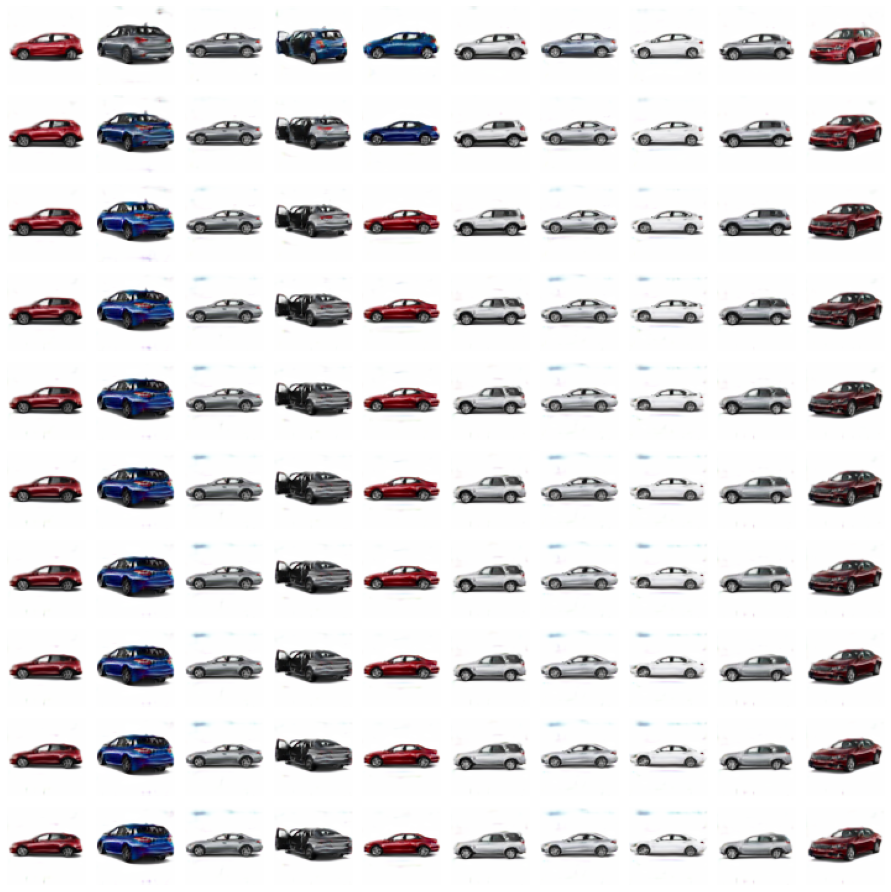

In [30]:
PATH = 'models/pairs/gen64SA_v1.pth'
#PATH = 'models/ccGan/gen128_41599.pth'

#netG = cont_cond_cnn_generator(nz=dim_gan).to(device)

n_row, n_col = 10,10
train_labels = LabelsTens.reshape(LabelsTens.shape[0])
start_label = np.quantile(train_labels, 0.05)
end_label = np.quantile(train_labels, 0.95)

selected_labels = np.linspace(start_label, end_label, num=n_row)

y_fixed = np.zeros(n_row*n_col)
for i in range(n_row):
    curr_label = selected_labels[i]
    for j in range(n_col):
        y_fixed[i*n_col+j] = curr_label
#print(y_fixed)
y_fixed = torch.from_numpy(y_fixed).type(torch.float).view(-1,1).to(device)

cp = torch.load(PATH)
netG.load_state_dict(cp['net_state_dict'])

z_fixed = torch.zeros((n_row*n_col, dim_gan)).to(device)
row = torch.randn(n_col, dim_gan, dtype=torch.float)
for i in range(n_col*n_row):
    z_fixed[i] = row[i%10]


with torch.no_grad():
    gen_imgs = netG(z_fixed, net_y2h(y_fixed))
    gen_imgs = gen_imgs.detach().cpu()
                        
    nb = n_row*n_col
    axes=[]
    fig=plt.figure(figsize = (nb/8,nb/8))

    pic = []
    for img in gen_imgs:
        pic.append(torch.clip(img.permute(1,2,0),0,1))

        
    for a in range(nb):
        b = pic[a]
        axes.append( fig.add_subplot(n_row, n_col, a+1) )
        plt.imshow(b)
        
        plt.axis('off')
    fig.tight_layout()    
    plt.show()